In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_runs(clients):
    mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    maxs = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    for i in clients:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
        j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
        j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))
        mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2), np.mean(j3)]
        maxs.loc[len(maxs)] = [np.max(j0), np.max(j1), np.max(j2), np.max(j3)]
        stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2), np.std(j3)]
    return mean, stds, maxs

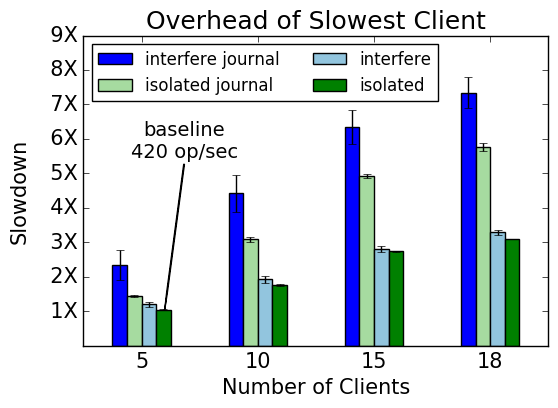

In [3]:
clients = [5, 10, 15, 18]
mean, stds, maxs = parse_runs(clients)
norm = np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"-nolog/*isolated*")))

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
cols = ["interfere journal", "isolated journal", "interfere", "isolated"]
m = maxs[cols]/norm; s = stds[cols]/norm
m.plot.bar(ax=ax, yerr=s, color=['blue', '#a6dba0', '#92c5de', 'green'])

# format
ax.set_title("Overhead of Slowest Client")
ax.legend(fontsize=12, ncol=2, loc='upper left')
ax.set_xlabel("Number of Clients")
ax.set_xticklabels(clients, rotation=0)
ax.set_ylabel("Slowdown")
ax.set_ylim(0, 9)
labels = ['{:3.0f}X'.format(x) for x in ax.get_yticks()]
labels[0] = ""
ax.set_yticklabels(labels)

# draw arrow
arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
args = {'horizontalalignment': 'center', 'verticalalignment': 'top', 'fontsize': 14, 'arrowprops': arrw}
val = maxs.iloc[0]
ax.annotate('baseline\n' + str(int(98000/val['isolated'])) + ' op/sec',
            xy=    (0.20, val['isolated']/norm),
            xytext=(0.37, val['isolated']/norm+5.5), **args)
#fig.savefig('../../../paper/graphs/slowdown-interfere-scale.png', bbox_inches='tight', dpi=400)

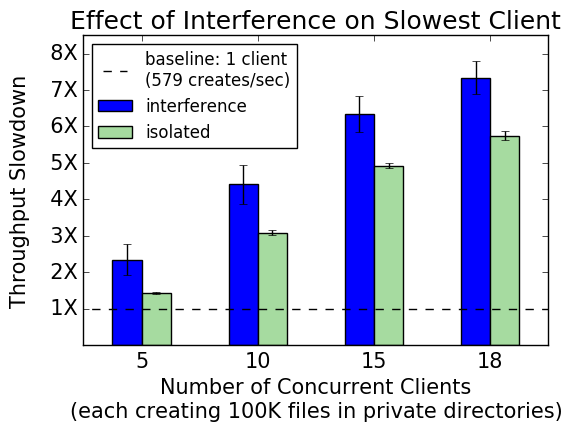

In [11]:
clients = [5, 10, 15, 18]
mean, stds, maxs = parse_runs(clients)
norm = np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"-nolog/*isolated*")))

m = maxs[["interfere journal", "isolated journal"]]/norm
s = stds[["interfere journal", "isolated journal"]]/norm
m.columns = ["interference", "isolated"]
s.columns = ["interference", "isolated"]

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
m.plot.bar(ax=ax, yerr=s, color=['blue', '#a6dba0', '#92c5de', 'green'])
ax.plot([-1, 5], [1, 1], color='black', ls='--',
        label='baseline: 1 client\n(' + str(int(98000/val['isolated'])) + ' creates/sec)')

# format
ax.set_title("Effect of Interference on Slowest Client")
ax.legend(fontsize=12, ncol=1, loc='upper left')
ax.set_xlabel("Number of Concurrent Clients\n(each creating 100K files in private directories)")
ax.set_xticklabels(clients, rotation=0)
ax.set_ylabel("Throughput Slowdown")
ax.set_ylim(0, 8.5)
labels = ['{:3.0f}X'.format(x) for x in ax.get_yticks()]
labels[0] = ""
ax.set_yticklabels(labels)

# draw arrow
#arrw = dict(facecolor='black', headwidth=10, width=1, shrink=1)
#args = {'horizontalalignment': 'center', 'verticalalignment': 'top', 'fontsize': 14, 'arrowprops': arrw}
#val = maxs.iloc[0]
#ax.annotate('baseline: 1 client\n(' + str(int(98000/val['isolated'])) + ' op/sec)',
#            xy=(0.5, 1), xytext=(0.3, 6.5), **args)
fig.savefig('../../../paper/graphs/slowdown-interfere-scale.png', bbox_inches='tight', dpi=400)

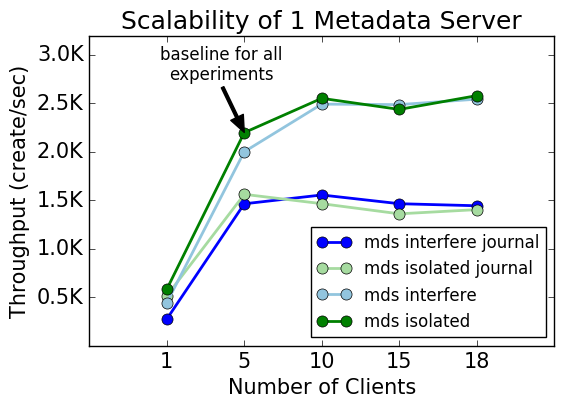

In [5]:
clients = [1, 5, 10, 15, 18]
mean, stds, maxs = parse_runs(clients)
cols_mds = []
for col in cols:
    mean['mds ' + col] = [c*98000 for c in clients]/mean[col]
    cols_mds.append('mds ' + col)
    
fig, ax = plt.subplots(1, 1)
mean[cols_mds].plot(ax=ax, lw=2, marker='o', ms=8, color=['blue', '#a6dba0', '#92c5de', 'green'])
ax.set_title("Scalability of 1 Metadata Server")
ax.set_ylabel("Throughput (create/sec)")
ax.set_ylim(0, 3200)
ax.set_xlabel("Number of Clients")
ax.set_xlim(-1, 5)
ax.set_xticklabels([""] + clients)
label = ['{:3.1f}K'.format(x/1000) for x in ax.get_yticks()]
label[0] = ""
ax.set_yticklabels(label)
ax.legend(fontsize=12, loc='lower right')

# draw arrow
arrw = dict(facecolor='black', headwidth=10, width=2, shrink=1)
args = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
val = maxs.iloc[0]
ax.annotate('baseline for all\nexperiments',
            xy=    (1, 2200),
            xytext=(0.7, 2900), **args)

fig.savefig('../../../paper/graphs/baseline.png', bbox_inches='tight', dpi=400)

In [6]:
# chek this!

   interfere journal  isolated journal   interfere    isolated
0         360.000000        191.000000  222.000000  169.000000
1         335.000000        314.000000  245.000000  223.000000
2         630.700000        669.400000  393.300000  384.100000
3        1004.333333       1081.533333  591.200000  603.200000
4        1222.888889       1257.666667  693.666667  683.944444


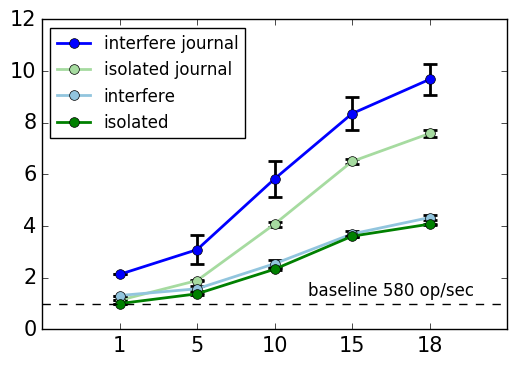

In [7]:
nfiles  = 98000
clients = [1, 5, 10, 15, 18]

mean, stds, maxs = parse_runs(clients)
norm = (nfiles/np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"-nolog/*isolated*"))))

m = nfiles/maxs[cols]
s = nfiles/stds[cols]
m = norm/m
s = norm/s
print mean

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
cols = ["interfere journal", "isolated journal", "interfere", "isolated"]
m.plot(ax=ax, yerr=s, lw=2, marker='o', ms=7, ecolor='black', capthick=2, capsize=5,
       color=['blue', '#a6dba0', '#92c5de', 'green'])
ax.plot([-1, 5], [1, 1], color='black', ls='--')
ax.set_xlim(-1, 5)
# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
ax.legend(handles, labels, fontsize=12, loc='upper left',numpoints=1)
#ax.legend(fontsize=12, loc='upper left')
ax.set_xticklabels(["", "1", "5", "10", "15", "18"])
ax.annotate('baseline ' + str(int(round(98000/float(mean['isolated'].head(1))))) + ' op/sec',
            xytext=(3.5, 1.5), xy=(3.5, 1.5), **args)

#fig.savefig('../../../paper/graphs/baseline.png', bbox_inches='tight', dpi=400)

   interfere journal  isolated journal  interfere  isolated
0              360.0             191.0      222.0     169.0
1              522.0             320.0      266.0     233.0
2              985.0             689.0      430.0     394.0
3             1412.0            1099.0      625.0     610.0
4             1636.0            1282.0      732.0     689.0
   interfere journal  isolated journal   interfere    isolated
0         272.222222        513.089005  441.441441  579.881657
1         187.739464        306.250000  368.421053  420.600858
2          99.492386        142.235123  227.906977  248.730964
3          69.405099         89.171975  156.800000  160.655738
4          59.902200         76.443058  133.879781  142.235123


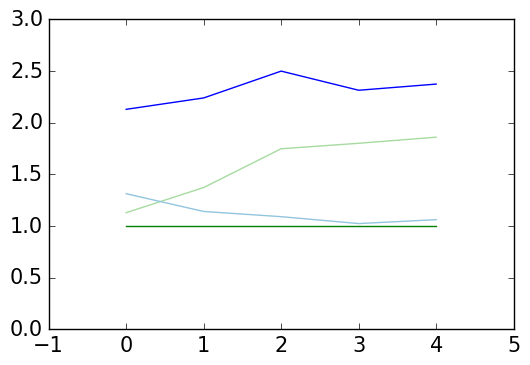

In [8]:
clients = [1, 5, 10, 15, 18]
mean, stds, maxs = parse_runs(clients)
norm = np.mean(parse_mdtest(glob.glob("../results-cloudlab-clients"+str(clients[0])+"-nolog/*isolated*")))
print maxs

tput = 98000/maxs
print tput
for col in tput.columns:
    tput[col] = tput['isolated']/tput[col]
    #tput[:].div(tput['isolated'], axis=0) 
tput
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
cols = ["interfere journal", "isolated journal", "interfere", "isolated"]
tput.plot(ax=ax, color=['blue', '#a6dba0', '#92c5de', 'green'])
ax.set_xlim(-1, 5)
ax.set_ylim(0, 3)
ax.legend().remove()